# Data Exploration for gdb041 and gdb056 database

This notebook will help to understand the structure, quality, and integrity of the dataset before performing further analytical tasks in SQL. The findings from this notebook will inform data cleaning decisions and ensure that subsequent analysis is built on reliable and well-understood data. From the findings of this data, the cleaning and rework process will be done in SQL.

## Part 1: Set up and Data loading

### 1.1: import necessary library

In [1]:
# Core libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

#import sql engine
from sqlalchemy import create_engine 

### 1.2: import and Load Data from SQL

### Database Configuration

This notebook reads database credentials from environment variables.
Credentials are **not stored in the notebook or repository**.

Required variables:
- DB_USER
- DB_PASSWORD
- DB_HOST
- DB_NAME

For local development:
- Create a `.env` file (see `.env.example`)
- Load variables using `python-dotenv`

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

engine = create_engine(
    f"mysql+mysqlconnector://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
)

query="SELECT * FROM gdb041.fact_sales_monthly_cleaned"
df_fact_sales=pd.read_sql(query, engine)
df_fact_sales.head()

,date,product_code,market,customer_code,sold_quantity
0,2017-09-01,A6218160101,Australia,70008169,81
1,2017-09-01,A6218160101,Australia,90008165,157
2,2017-09-01,A6218160101,Australia,90008166,126
3,2017-09-01,A6218160101,Australia,90008167,160
4,2017-09-01,A6218160101,Australia,70008170,120


### 1.3: inspect data to see 

1. Total Rows, Column
2. Data Types for each column
3. Mixed data type for any column
4. Distinct values per column
5. Null Values and percentage per column
6. Duplicate rows in dataset
7. Negative and Zero values in quantitative column

In [3]:
def initial_report(df):
    print(f"*** Structure:\n- Total Rows: {df.shape[0]}\n- Total Columns: {df.shape[1]}")
    print(f"- Column Names: {list(df.columns)}\n")

    
    print("*** Data Types:")
    for col, dtype in df.dtypes.items():
        print(f"  {col}: {dtype}")
    print()

    print("*** Mixed Data Types:")
    has_mixed_types = False
    for col in df.columns:
        try:
            type_counts = df[col].apply(type).value_counts()
            if len(type_counts) > 1:
                has_mixed_types = True
                print(f"  {col}:")
                for t, count in type_counts.items():
                    print(f"    - {t.__name__}: {count}")
        except Exception as e:
            print(f"  {col}: Error checking types - {e}")

    if not has_mixed_types:
        print("  No mixed data types found")
    print()

    print("*** Distinct Values per Column:")
    for col in df.columns:
        print(f"  {col}: {df[col].nunique()}")
    print()

    print("*** Null Values and Percentages:")
    has_null_value=False
    nulls = df.isnull().sum()
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        if nulls[col] > 0: # Only print if there are missing values
            has_null_value=True
            print(f"  {col}: Missing Values: {nulls[col]}, Pct: {round(pct_missing * 100, 3)}%")
    if not has_null_value:
        print("  No null values found")
    print()

    
    print(f"\n*** Duplicates: {df.duplicated().sum()}")

    
    print("*** Negative or Zero Values:")
    has_issues = False
    for col in df.select_dtypes(include='number').columns:
        zero_count = (df[col] == 0).sum()
        negative_count = (df[col] < 0).sum()
    
        if zero_count > 0 or negative_count > 0:
            has_issues = True
            print(f"  {col}:")
            if zero_count > 0:
                print(f"    - Zero values: {zero_count}")
            if negative_count > 0:
                print(f"    - Negative values: {negative_count}")

    if not has_issues:
        print("  No negative or zero values found")
    print()

initial_report(df_fact_sales)

*** Structure:
- Total Rows: 1425706
- Total Columns: 5
- Column Names: ['date', 'product_code', 'market', 'customer_code', 'sold_quantity']

*** Data Types:
  date: datetime64[ns]
  product_code: object
  market: object
  customer_code: object
  sold_quantity: int64

*** Mixed Data Types:
  No mixed data types found

*** Distinct Values per Column:
  date: 52
  product_code: 389
  market: 27
  customer_code: 209
  sold_quantity: 2991

*** Null Values and Percentages:
  No null values found


*** Duplicates: 0
*** Negative or Zero Values:
  sold_quantity:
    - Zero values: 783



# Comment:
- Total column is 11
- Total rows is 1425706.
- Data Type: No Issues
- No Mixed Data Type
- Distinct values per column: date: 52, product_code: 389, market=27, customer_code: 209, sold_quantity: 2991
- No Null
- No Duplicate
- Zero values: 783.

As market has only 27 distinct values, I can use it as a slicer in power bi.

According to **Ref: 8. SQL_where_sold_quantity_is_zero**, 

Multiple customers in the Germany market have repeated records on the same date where sold_quantity equals zero. Each customer has 87 zero‑quantity entries for 2017‑09‑01, suggesting a pattern that is unlikely to be random. However, the product manager suggested to keep it as it is. We assume that no products are sold in that specific date on that specific market.

### 1.4: Check Basic statistics

In [4]:
df_fact_sales.describe()

,date,sold_quantity
count,1425706,1.425706e+06
mean,2020-08-04 23:49:06.654639616,8.788036e+01
min,2017-09-01 00:00:00,0.000000e+00
25%,2019-12-01 00:00:00,4.000000e+00
50%,2020-11-01 00:00:00,1.700000e+01
75%,2021-06-01 00:00:00,7.700000e+01
max,2021-12-01 00:00:00,5.832000e+03
std,NaN,2.080257e+02


# Comment:
### Date:
- Min Date: 2017-09-01
- Max Date: 2021-12-01
- Median (2020-11) is later than mean (2020-08) → Indicates more data density in later years
### Sold_quantity:
- This distribution is strongly right-skewed evidence by Mean (87.9) ≫ Median (17). The high standard deviation (208) related to the mean (87.9) confirms significant volatility. While 75% of the transaction involves 77 units or fewer, the maximum value reaches 5,832; indicating a long-tail of extreme outliers. The data implies that most of the sales are concentrated in specific market/product/customer.
  
 **Which markets are dominating the sold_quantity and which are more and less volatile?**
 
 According to **Ref: 9. SQL_markets_dominating_sales**
 
- Top 3 in terms of volume includes india, USA, South Korea --
- Top 3 in terms of biggest_single_sale includes South Korea, India, China --
- Top 3 in terms of average per sale South Korea, India, USA --

According to **Ref: 10. SQL_volatility_index_sold_quantity**
- Top 3 reliable market Columbia, Chile, Austria --
- Top 3 volatile market China, Philipines, South Korea --
  

5.847867926947904


C:\Users\irfan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


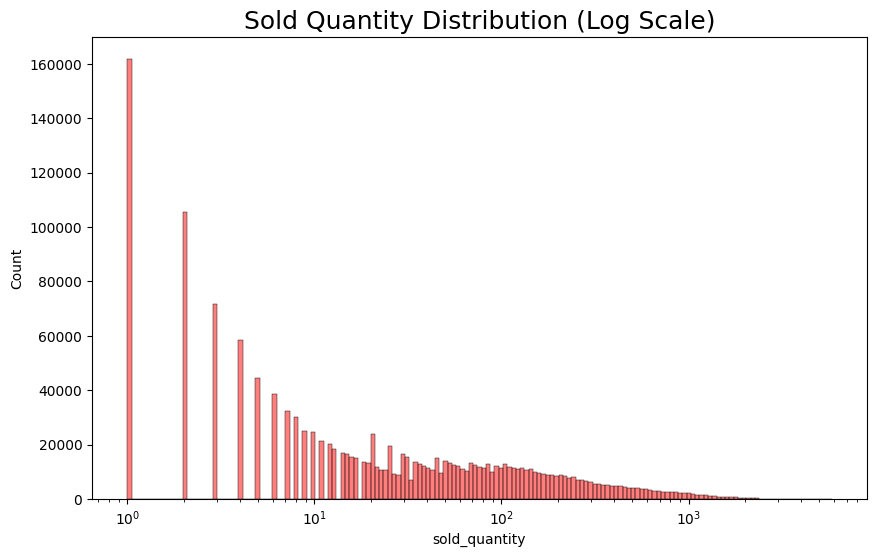

In [5]:
#check skew
print(df_fact_sales['sold_quantity'].skew())

import seaborn as sns
import matplotlib.pyplot as plt

#distribution plot to check how data is spread, to check skewness
plt.figure(figsize=(10,6))
# Using histplot with log_scale
sns.histplot(df_fact_sales.sold_quantity, color='r', kde=True, log_scale=True)
plt.title('Sold Quantity Distribution (Log Scale)', size=18)
plt.show()

# Comment:
Extremely right-skewed

In [6]:
def outliers_iqr(df, columns=None):
    """
    Detect outliers in a DataFrame using the Interquartile Range (IQR) method.
    
    Returns: outlier information for each column
    """
    import pandas as pd
    
    # Select columns to analyze
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    print("*** Outliers (IQR method):")
    
    for col in columns:
        # Calculate IQR bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers = df[outlier_mask]
        outlier_count = len(outliers)
        
        # Print summary
        if outlier_count > 0:
            print(f"  {col}: {outlier_count} outliers")
        else:
            print(f"  {col}: No outliers")
        print(f"    Lower Bound: {lower_bound:.2f}")
        print(f"    Upper Bound: {upper_bound:.2f}")
    


# usage:
outliers_iqr(df_fact_sales)

*** Outliers (IQR method):
  sold_quantity: 172069 outliers
    Lower Bound: -105.50
    Upper Bound: 186.50


In [ ]:
### 1.5: Check Outliers

In [8]:
def outliers_iqr(df, columns=None):
    """
    Detect outliers in a DataFrame using the Interquartile Range (IQR) method.
    
    Returns: outlier information for each column
    """
    import pandas as pd
    
    # Select columns to analyze
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    print("*** Outliers (IQR method):")
    
    for col in columns:
        # Calculate IQR bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers = df[outlier_mask]
        outlier_count = len(outliers)
        
        # Print summary
        if outlier_count > 0:
            print(f"  {col}: {outlier_count} outliers")
        else:
            print(f"  {col}: No outliers")
        print(f"    Lower Bound: {lower_bound:.2f}")
        print(f"    Upper Bound: {upper_bound:.2f}")
    


# usage:
outliers_iqr(df_fact_sales)

*** Outliers (IQR method):
  sold_quantity: 172069 outliers
    Lower Bound: -105.50
    Upper Bound: 186.50


### 1.6: Check value_counts from market column

In [13]:
df_fact_sales.market.value_counts()

market
India             147278
USA               121400
Canada             84873
Italy              80172
Portugal           77571
France             77365
United Kingdom     77030
Germany            76859
Spain              59350
Netherlands        56532
Australia          55612
Poland             53018
Japan              52477
Norway             50343
Philiphines        47798
Newzealand         44815
South Korea        40922
Austria            34938
Pakistan           34374
Bangladesh         33484
Indonesia          31996
Sweden             25174
China              23031
Brazil             14021
Mexico             12736
Chile               8755
Columbia            3782
Name: count, dtype: int64